# Kaggle Tabular Series S3E3

## Libraries

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

## UDF

In [314]:
# Function to plot the ROC curve
def plot_roc(y_test, y_score,y_train, y_score_train):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    # Compute micro-average ROC curve and ROC area
    fpr_train["micro"], tpr_train["micro"], _ = metrics.roc_curve(y_train.ravel(), y_score_train.ravel())
    roc_auc_train["micro"] = metrics.auc(fpr_train["micro"], tpr_train["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot(fpr_train["micro"], tpr_train["micro"], color='green',
             lw=lw, label='Training ROC curve (area = %0.2f)' % roc_auc_train["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## File Reading and Basic Variable Analysis

We read the training file and print the first line to have sense on how it looks

In [315]:
df = pd.read_csv('/Users/pabloserranomolinero/Downloads/playground-series-s3e3/train.csv')
df.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


We check variables types

In [316]:
# Columns types
df.dtypes

id                           int64
Age                          int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYea

We describe the numerical variables that we have to check for anomalies and to understand their values

In [317]:
# Perform describe on num data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1677.0,838.000000,484.252517,0.0,419.0,838.0,1257.0,1676.0
Age,1677.0,36.036971,8.507112,18.0,30.0,35.0,41.0,60.0
DailyRate,1677.0,892.749553,374.496259,107.0,589.0,890.0,1223.0,3921.0
DistanceFromHome,1677.0,8.683959,7.826143,1.0,2.0,7.0,12.0,29.0
Education,1677.0,2.937984,1.039078,1.0,2.0,3.0,4.0,15.0
EmployeeCount,1677.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
EnvironmentSatisfaction,1677.0,2.757901,1.086835,1.0,2.0,3.0,4.0,4.0
HourlyRate,1677.0,67.798450,19.435928,30.0,51.0,69.0,84.0,100.0
JobInvolvement,1677.0,2.782349,0.650664,1.0,2.0,3.0,3.0,4.0
JobLevel,1677.0,1.998807,1.083065,1.0,1.0,2.0,2.0,7.0


We will fix some values that are not correct, such as JobLevel > 5, which is not possible.

In [318]:
# We delete jobLevel greater than 5
df = df[df['JobLevel'] <= 5]

# We delete Education greater than 5
df = df[df['Education'] <= 5]

# Remove values above 95 percentile for daily rate
df = df[df['DailyRate'] <= df['DailyRate'].quantile(0.95)]

Let's check now the number of missing values we have in each variable.

In [319]:
# Data frame missing values
df.isnull().sum()

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

Fortunetly we dont have any missing values

Now we will check if we have variables with constant values

In [320]:
col = list(df.columns)
for i in col: 
    print(i,df[i].nunique())

id 1596
Age 43
BusinessTravel 3
DailyRate 596
Department 3
DistanceFromHome 29
Education 5
EducationField 6
EmployeeCount 1
EnvironmentSatisfaction 4
Gender 2
HourlyRate 71
JobInvolvement 4
JobLevel 5
JobRole 9
JobSatisfaction 4
MaritalStatus 3
MonthlyIncome 869
MonthlyRate 880
NumCompaniesWorked 10
Over18 1
OverTime 2
PercentSalaryHike 15
PerformanceRating 2
RelationshipSatisfaction 4
StandardHours 1
StockOptionLevel 4
TotalWorkingYears 41
TrainingTimesLastYear 7
WorkLifeBalance 4
YearsAtCompany 34
YearsInCurrentRole 19
YearsSinceLastPromotion 16
YearsWithCurrManager 18
Attrition 2


We see some variables that have constant values so we will remove them

In [321]:
# List of variables with more than one value
keep_cols = df.columns[df.nunique()>1]

#Update DF
df = df[keep_cols]

We will now check the histograms of the numeric variables

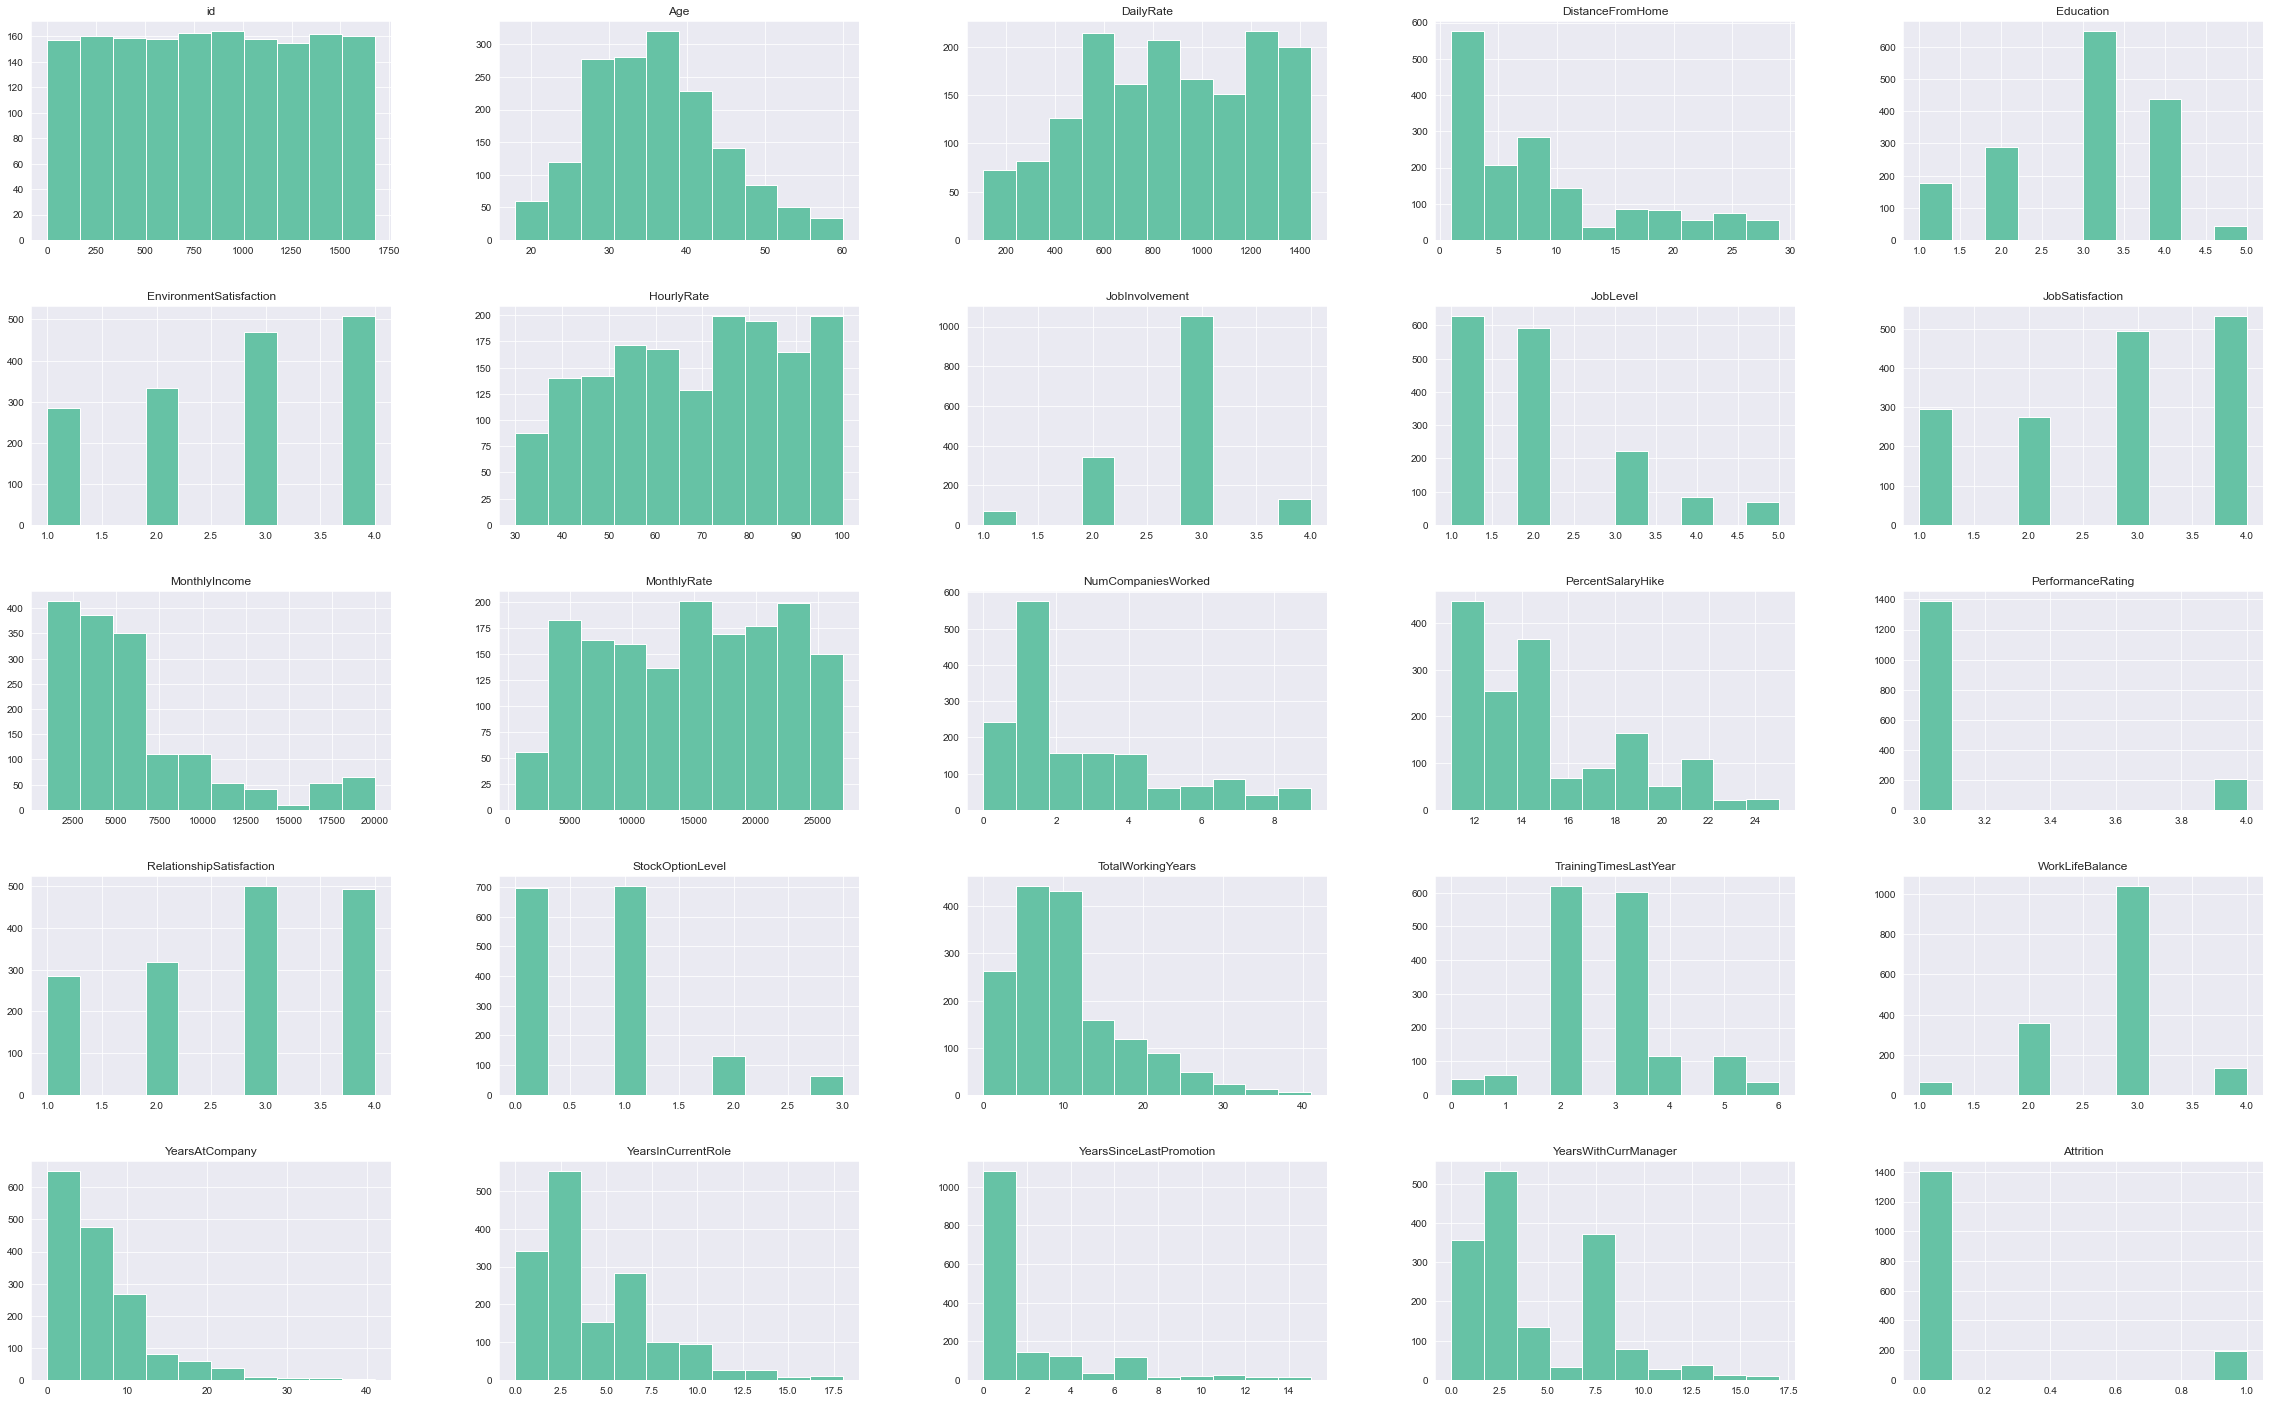

In [322]:
# We fill the missing values with the mean of the numeric columns
numeric_variables = list(df.select_dtypes(include=['int64', 'float64']).columns)

fig, axs = plt.subplots(5, 5, figsize=(40, 25))
for ax, col in zip(axs.flatten(), numeric_variables):
    df.hist(column=col, ax=ax)

We see some variables that have a rly skewed distribution. We could try to make them more Normal-ish by calculating their log

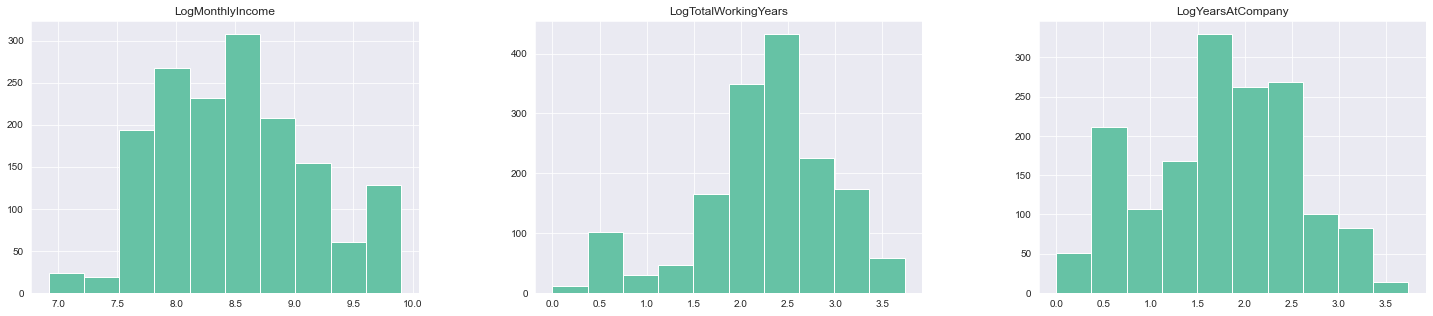

In [323]:
# We list the variables that we want to log transform
log_col = ['MonthlyIncome','TotalWorkingYears','YearsAtCompany']

fig, axs = plt.subplots(1, 3, figsize=(25, 5))
for ax, cols in zip(axs.flatten(), log_col):
    df['Log' + cols] = np.log( 1 + df[cols])
    df.hist(column='Log'+cols, ax=ax)

We see that now we have more normal distributions

We will now check those distributions depending on the value of the target variable

We first check the distribution of the target variable

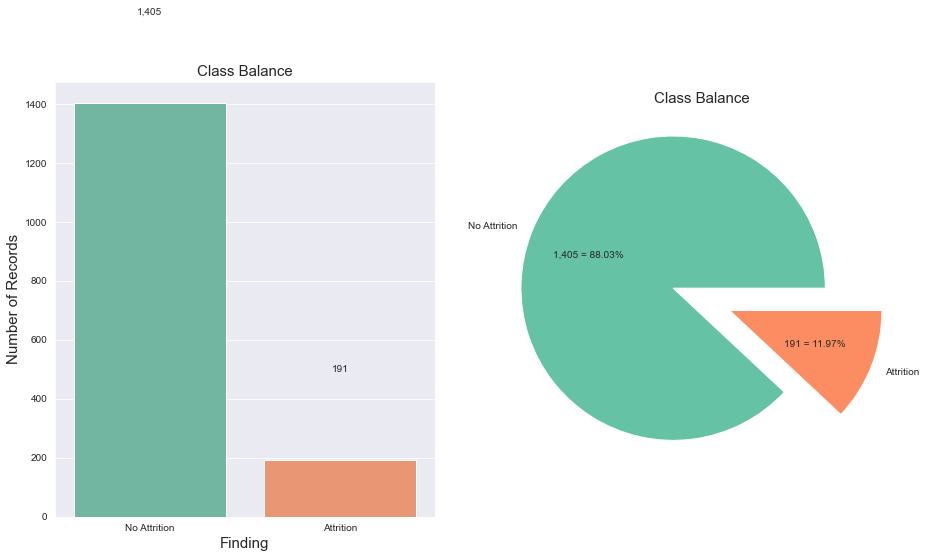

In [324]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.set_style('darkgrid')
sns.set_palette('Set2')

counts = pd.DataFrame(df["Attrition"].value_counts()).rename(index={0: "No Attrition", 1: "Attrition"})
_ = sns.barplot(x=counts.index, y=counts.Attrition, ax=axs[0])
for p in axs[0].patches:
    axs[0].text(x=p.get_x()+(p.get_width()/2), y=p.get_height()+300, s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs[0].set_title("Class Balance", fontsize=15)
_ = axs[0].set_ylabel("Number of Records", fontsize=15)
_ = axs[0].set_xlabel("Finding", fontsize=15)

data = [
    df[(df["Attrition"] == 0)]["id"].count(),
    df[(df["Attrition"] == 1)]["id"].count()
]
_ = axs[1].pie(
    data, labels=["No Attrition", "Attrition"],
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
    explode=[0.20] * 2, 
    colors=sns.color_palette("Set2")[0:2],
)
_ = axs[1].set_title("Class Balance", fontsize=15)

Now we will check the distribution of the numeric variables depending on the value of the target variable

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


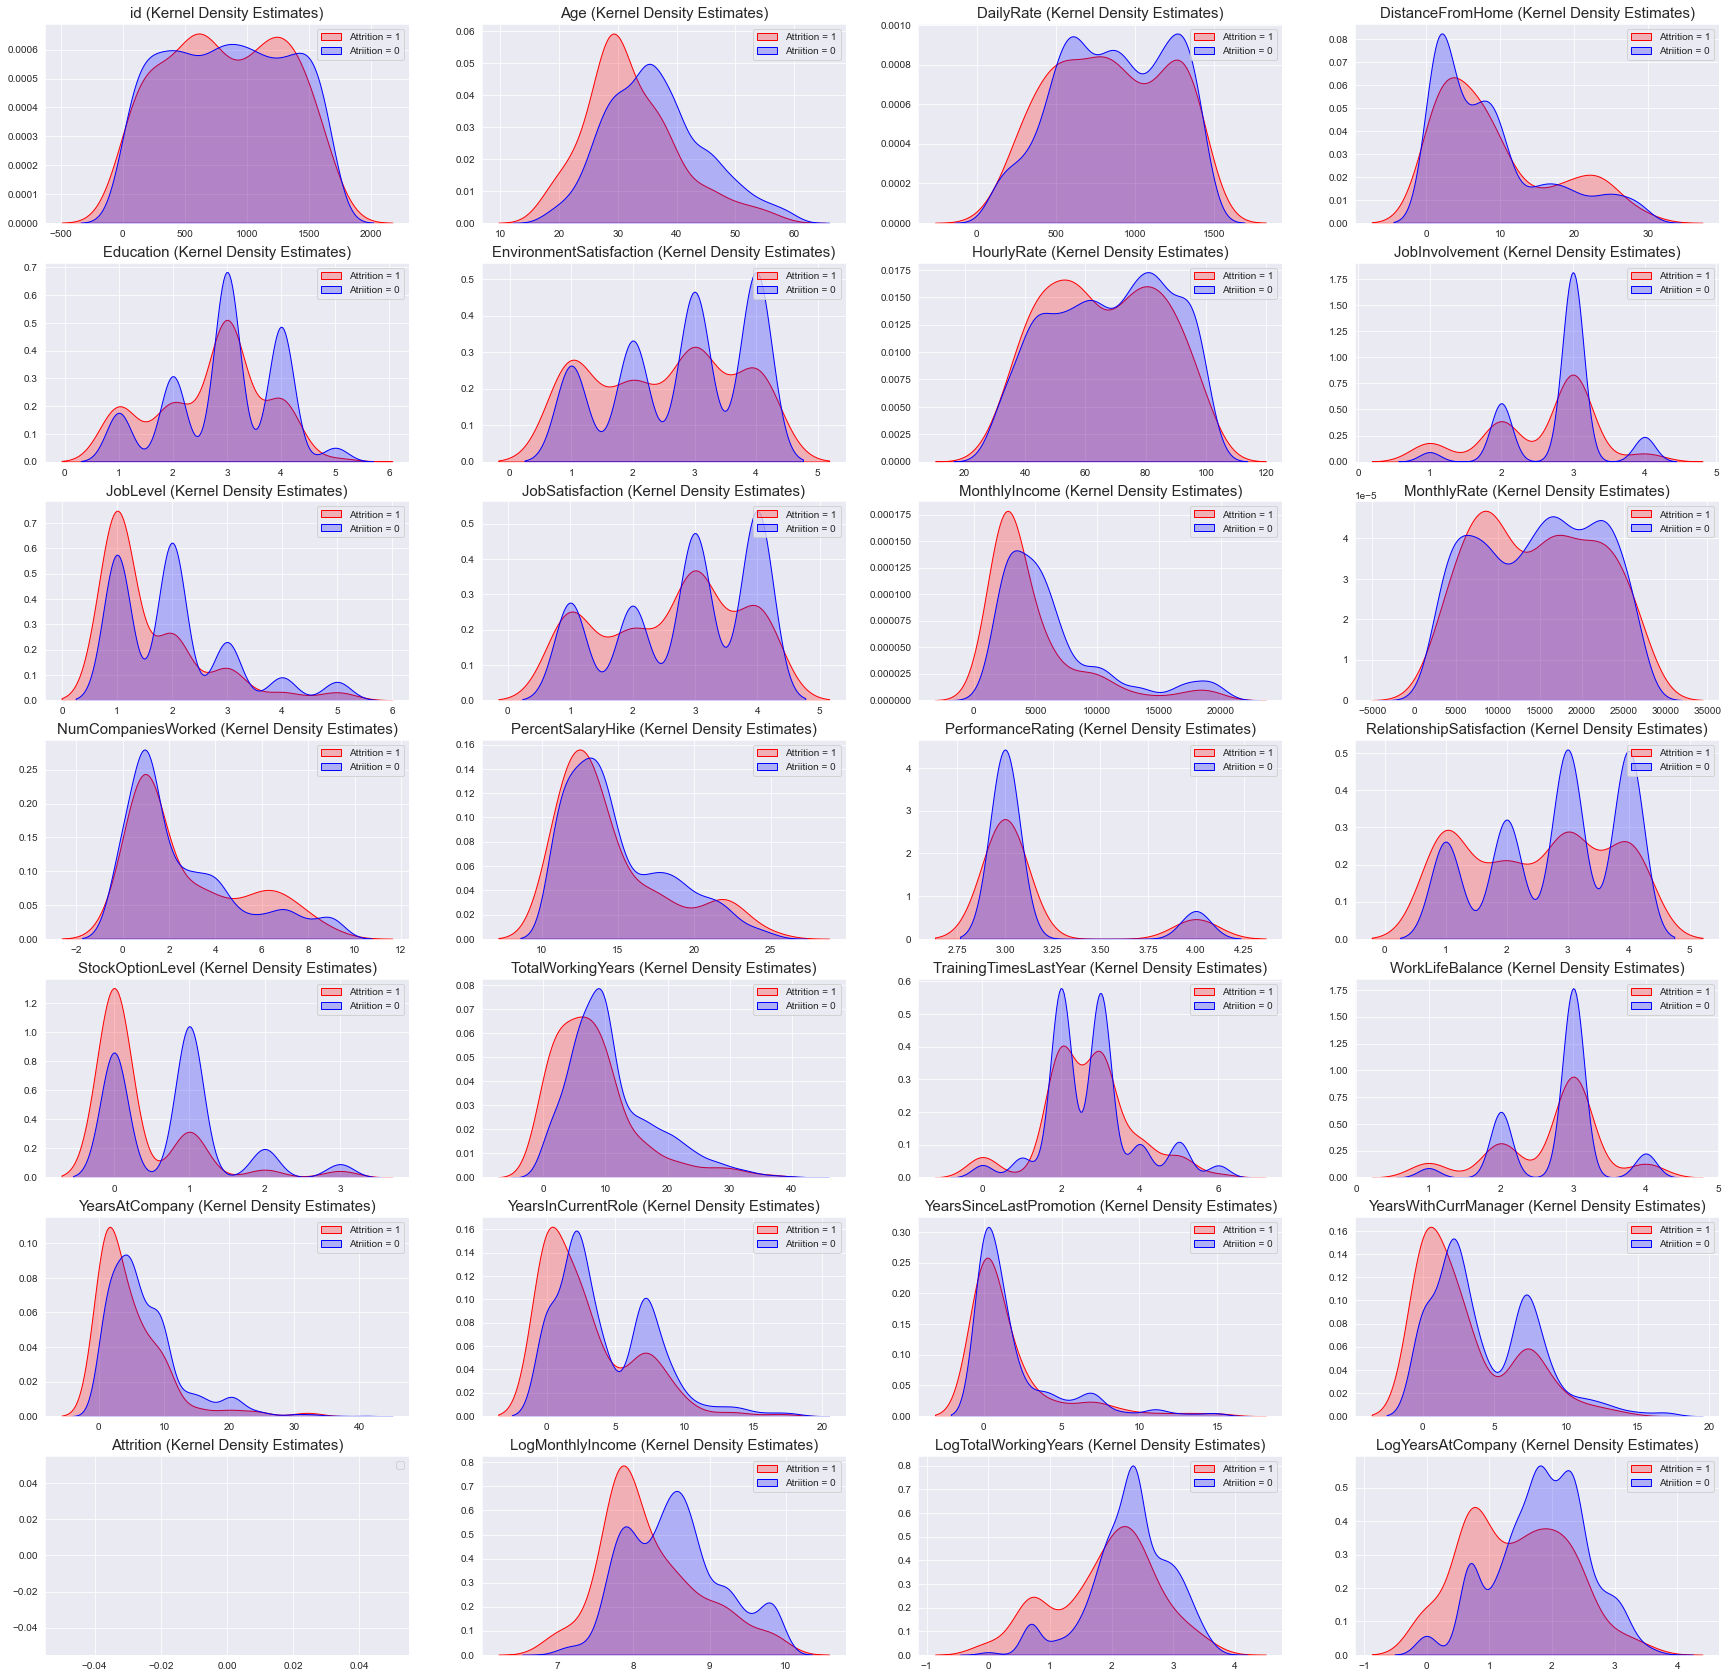

In [325]:
numeric_variables = list(df.select_dtypes(include=['int64', 'float64']).columns)

fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(30, 30))

sns.set_style('darkgrid')

axs = axs.flatten()

axis_counter = 0

for _, feature in enumerate(numeric_variables):
    _ = sns.kdeplot(df[feature][df['Attrition'] == 1], shade=True, color="r", ax=axs[axis_counter], label="Attrition = 1")
    _ = sns.kdeplot(df[feature][df['Attrition'] == 0], shade=True, color="b", ax=axs[axis_counter], label="Atriition = 0")
    _ = axs[axis_counter].set_title("{} (Kernel Density Estimates)".format(feature), fontsize=15)
    _ = axs[axis_counter].set_ylabel("")
    _ = axs[axis_counter].set_xlabel("")
    handles, labels = axs[axis_counter].get_legend_handles_labels()
    axs[axis_counter].legend(handles=handles, labels=labels, title="")   
    axis_counter += 1

We see some differences between the distributions of the target variable depending on the value of the target variable, this could be a good indicator for the model. 

We will now check the categorical variables

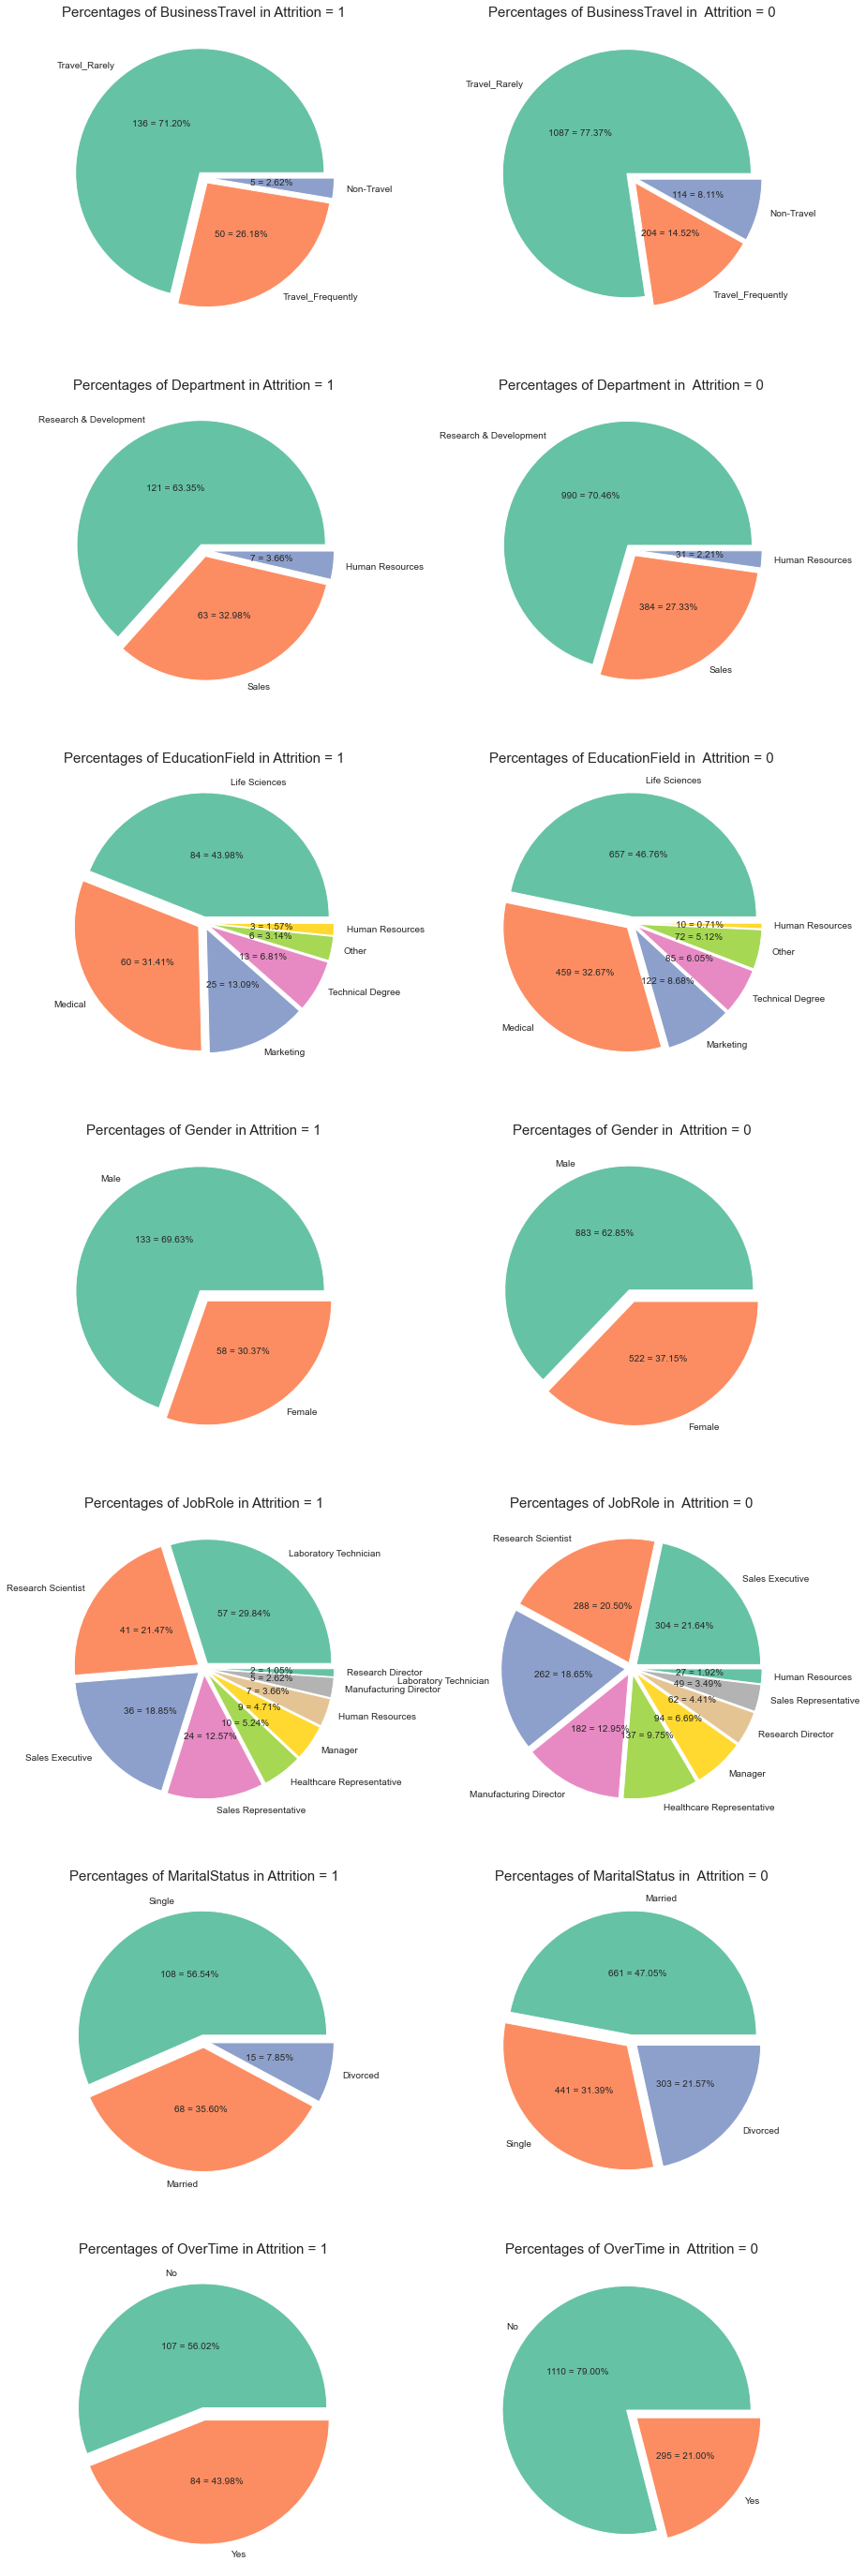

In [326]:
char_variables = list(df.select_dtypes(include=['object']).columns)

fig, axs = plt.subplots(nrows=len(char_variables), ncols=2, figsize=(15, 50))
sns.set_style('darkgrid')
axs = axs.flatten()
axis_counter = 0

train_temp = df[df['Attrition'] == 1].copy()
test_temp = df[df['Attrition'] == 0].copy()


for _, feature in enumerate(char_variables):
    data = train_temp[feature].value_counts().to_dict()
    keys, values = data.keys(), data.values()
    _ = axs[axis_counter].pie(
        values, labels=keys,
        autopct=lambda x: "{:.0f} = {:.2f}%".format(x * sum(values)/100, x),
        explode=[0.05] * len(keys), 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:len(keys)],
    )
    _ = axs[axis_counter].set_title("Percentages of {} in Attrition = 1".format(feature), fontsize=15)
    axis_counter += 1

    data = test_temp[feature].value_counts().to_dict()
    keys, values = data.keys(), data.values()
    _ = axs[axis_counter].pie(
        values, labels=keys,
        autopct=lambda x: "{:.0f} = {:.2f}%".format(x * sum(values)/100, x),
        explode=[0.05] * len(keys), 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:len(keys)],
    )
    _ = axs[axis_counter].set_title("Percentages of {} in  Attrition = 0".format(feature), fontsize=15)
    axis_counter += 1

As we can see we find some differences between the target variable depending on the value of the categorical variables. This could be again a good indicator for the model.

As we have available more data related with the problem, we will load it and check the variables.

In [327]:
# Read new data
df2 = pd.read_csv('/Users/pabloserranomolinero/Downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Rename employeeNumber to id
df2.rename(columns={'EmployeeNumber':'id'}, inplace=True)

# List of variables with more than one value
df2 = df2[keep_cols]

#Calculate log variables
for ax, cols in zip(axs.flatten(), log_col):
    df2['Log' + cols] = np.log( 1 + df2[cols])
    
# Describe num data
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1470.0,1024.865306,602.024335,1.000000,491.250000,1020.500000,1555.750000,2068.000000
Age,1470.0,36.923810,9.135373,18.000000,30.000000,36.000000,43.000000,60.000000
DailyRate,1470.0,802.485714,403.509100,102.000000,465.000000,802.000000,1157.000000,1499.000000
DistanceFromHome,1470.0,9.192517,8.106864,1.000000,2.000000,7.000000,14.000000,29.000000
Education,1470.0,2.912925,1.024165,1.000000,2.000000,3.000000,4.000000,5.000000
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.000000,2.000000,3.000000,4.000000,4.000000
HourlyRate,1470.0,65.891156,20.329428,30.000000,48.000000,66.000000,83.750000,100.000000
JobInvolvement,1470.0,2.729932,0.711561,1.000000,2.000000,3.000000,3.000000,4.000000
JobLevel,1470.0,2.063946,1.106940,1.000000,1.000000,2.000000,3.000000,5.000000
JobSatisfaction,1470.0,2.728571,1.102846,1.000000,2.000000,3.000000,4.000000,4.000000


We can see that the values of the variables are pretty similar to the ones provided at first. To be sure we will also compare distributions.

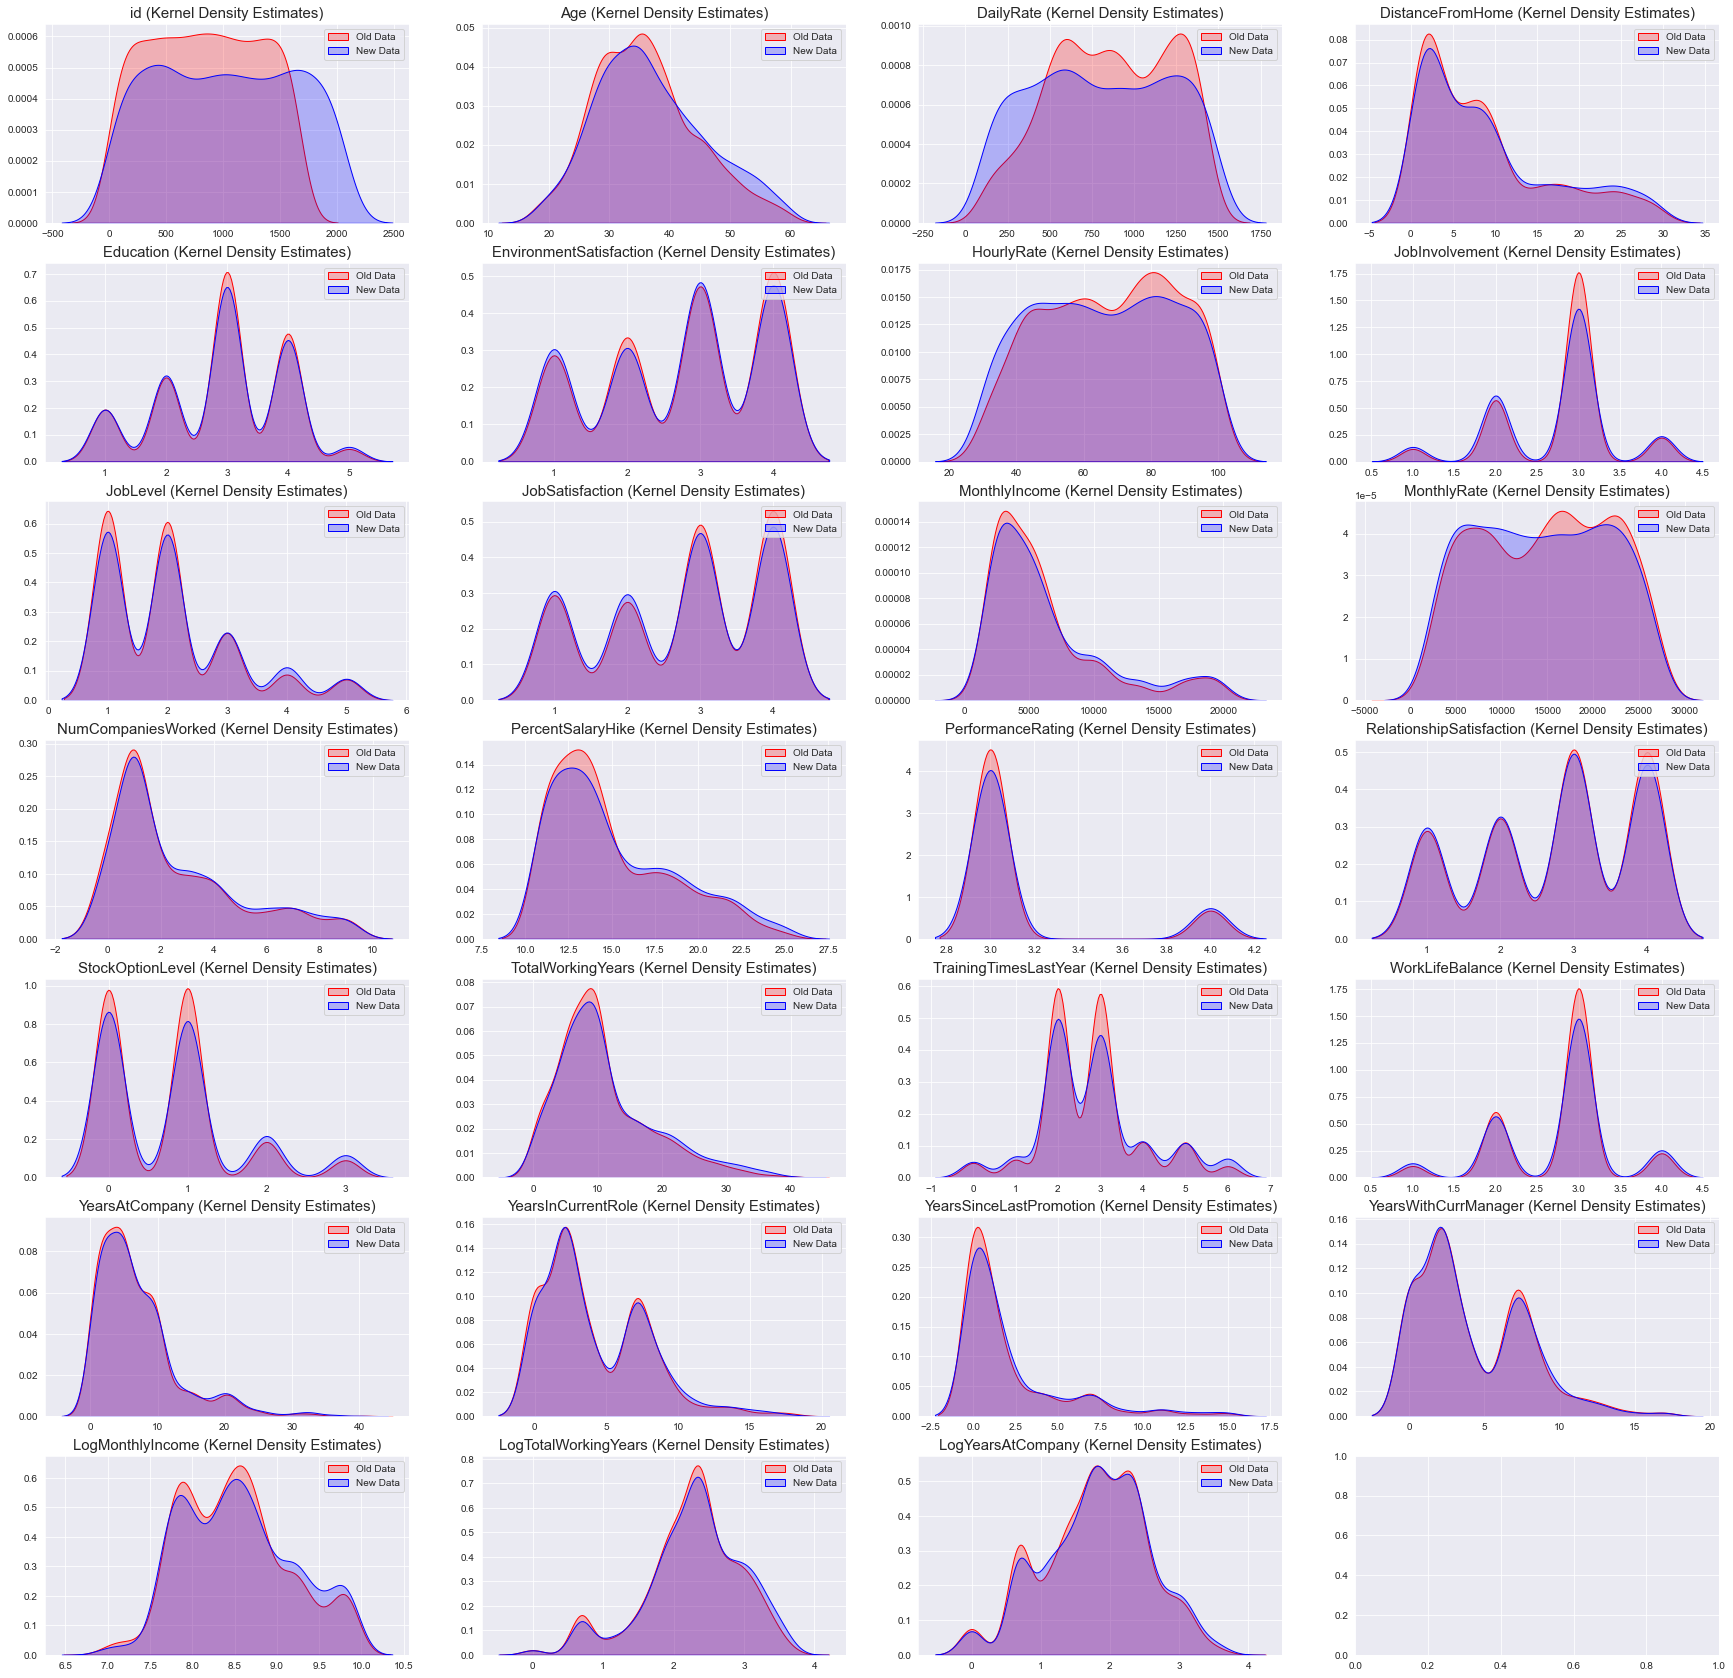

In [328]:
numeric_variables = list(df2.select_dtypes(include=['int64', 'float64']).columns)

fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(30, 30))

sns.set_style('darkgrid')

axs = axs.flatten()

axis_counter = 0

for _, feature in enumerate(numeric_variables):
    _ = sns.kdeplot(df[feature], shade=True, color="r", ax=axs[axis_counter], label="Old Data")
    _ = sns.kdeplot(df2[feature], shade=True, color="b", ax=axs[axis_counter], label="New Data")
    _ = axs[axis_counter].set_title("{} (Kernel Density Estimates)".format(feature), fontsize=15)
    _ = axs[axis_counter].set_ylabel("")
    _ = axs[axis_counter].set_xlabel("")
    handles, labels = axs[axis_counter].get_legend_handles_labels()
    axs[axis_counter].legend(handles=handles, labels=labels, title="")   
    axis_counter += 1

We will now check the number of occurrences of attrition in each dataset

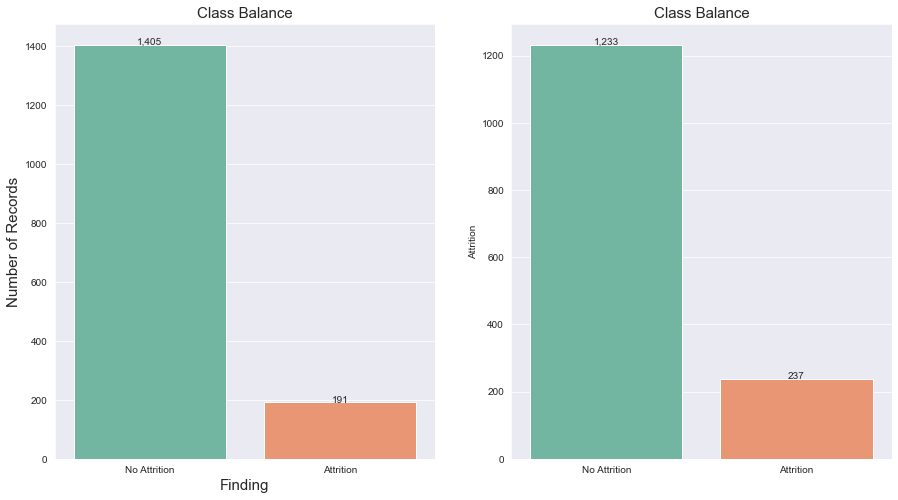

In [329]:
# Compare attrition in each dataset
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.set_style('darkgrid')
sns.set_palette('Set2')

counts = pd.DataFrame(df["Attrition"].value_counts()).rename(index={0: "No Attrition", 1: "Attrition"})
counts2 = pd.DataFrame(df2["Attrition"].value_counts()).rename(index={'No': "No Attrition", 'Yes': "Attrition"})

_ = sns.barplot(x=counts.index, y=counts.Attrition, ax=axs[0])
for p in axs[0].patches:
    axs[0].text(x=p.get_x()+(p.get_width()/2), y=p.get_height(), s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs[0].set_title("Class Balance", fontsize=15)
_ = axs[0].set_ylabel("Number of Records", fontsize=15)
_ = axs[0].set_xlabel("Finding", fontsize=15)

_ = sns.barplot(x=counts2.index, y=counts2.Attrition, ax=axs[1])
for p in axs[1].patches:
    axs[1].text(x=p.get_x()+(p.get_width()/2), y=p.get_height(), s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs[1].set_title("Class Balance", fontsize=15)


We see that the number of occurrences of attrition and variable distributions are pretty similar in both datasets, so we can use the data from the second dataset to train the model.

In [330]:
# Change Attrition to 0 and 1
df2['Attrition'] = df2['Attrition'].map({'No': 0, 'Yes': 1})

# Join both datasets
df = pd.concat([df, df2], axis=0)

# Reset index
df.reset_index(drop=True, inplace=True)

## Feature Engineering

We will perform some feature engineering to create new variables that could be useful for the model

In [331]:
# Average years at a company
df['LogAvgYearsAtCompany'] = np.log(df['TotalWorkingYears'] / (df['NumCompaniesWorked'])+1)
# If variable is infinity set to 0
df['LogAvgYearsAtCompany'] = df['LogAvgYearsAtCompany'].replace([np.inf, -np.inf], 0)

We chwck the new variables

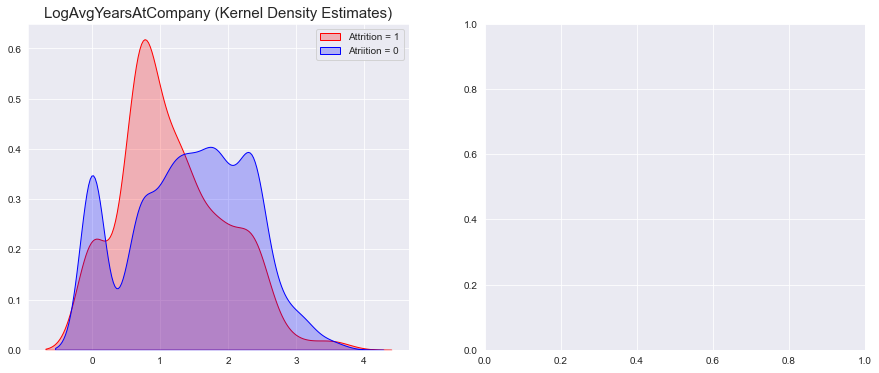

In [332]:
features = ['LogAvgYearsAtCompany']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.set_style('darkgrid')

axs = axs.flatten()

axis_counter = 0

for _, feature in enumerate(features):
    _ = sns.kdeplot(df[feature][df['Attrition'] == 1], shade=True, color="r", ax=axs[axis_counter], label="Attrition = 1")
    _ = sns.kdeplot(df[feature][df['Attrition'] == 0], shade=True, color="b", ax=axs[axis_counter], label="Atriition = 0")
    _ = axs[axis_counter].set_title("{} (Kernel Density Estimates)".format(feature), fontsize=15)
    _ = axs[axis_counter].set_ylabel("")
    _ = axs[axis_counter].set_xlabel("")
    handles, labels = axs[axis_counter].get_legend_handles_labels()
    axs[axis_counter].legend(handles=handles, labels=labels, title="")   
    axis_counter += 1

We delete some variables that we find irrelevant for our model. Also we generate the features and target dataframes for train/test split

In [333]:
# We create two new data frames, one with the features and the other with the target
Features = df.loc[:, df.columns.difference(['id','Attrition','MonthlyIncome','TotalWorkingYears','YearsAtCompany'])]
char_features = list(Features.select_dtypes(include=['object']).columns)
y = df['Attrition']
Features

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,4,Male,42,...,Yes,13,3,2,1,2,3,0,7,8
1,35,Travel_Rarely,921,Sales,8,3,Other,1,Male,46,...,No,17,3,4,1,3,3,2,0,3
2,32,Travel_Rarely,718,Sales,26,3,Marketing,3,Male,80,...,No,17,3,4,2,3,3,2,1,2
3,50,Travel_Rarely,1017,Research & Development,5,4,Medical,2,Female,37,...,Yes,13,3,3,0,0,3,14,4,10
4,27,Travel_Rarely,566,Research & Development,2,3,Other,3,Female,56,...,No,11,3,4,0,0,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,36,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,41,...,No,17,3,3,1,3,3,2,0,3
3062,39,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,42,...,No,15,3,1,1,5,3,7,1,7
3063,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,...,Yes,20,4,2,1,0,3,2,0,3
3064,49,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,63,...,No,14,3,4,0,3,2,6,0,8


We generate dummy variables for the categorical variables and split the data in train and test

In [334]:
# Generate binary values using get_dummies
dum_df = pd.get_dummies(Features[char_features], columns=char_features, prefix=char_features)
X = Features.join(dum_df, how='left')
X = X.drop(list(Features.select_dtypes(include=['object']).columns), axis=1)

rus = RandomUnderSampler(random_state=4321, sampling_strategy={0: 2000, 1: 428})
X_resampled, y_resampled = rus.fit_resample(X, y)

# We split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
     X_resampled, y_resampled, test_size=0.1, random_state=4321)

We define a parameters grid to find the best model

We will try now XGBoost model

In [335]:
# We create the data matrix
data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical=True)

# Parameters for the grid search
params = {
        'learning_rate': np.linspace(0.01, 0.3, 10),
        'n_estimators' : range(0, 100, 25),
        'subsample': [0.6,0.8],
        'gamma': [0.1,1,3,5],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [3, 5]
        }

# Create the model 
xgb_model = xgb.XGBClassifier(objective ='binary:logistic')

grid_xgboost = GridSearchCV(xgb_model, param_grid = params, 
                          cv = 5, n_jobs = -1, verbose = 1, scoring='roc_auc')

# Train the model
grid_xgboost.fit(X_train,y_train)

# We predict the test data to check the accuracy
print('Test Score : ',grid_xgboost.score(X_test, y_test))
print('Champion model parameters : ',grid_xgboost.best_params_)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
Test Score :  0.8794881588999235
Champion model parameters :  {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.10666666666666666, 'max_depth': 3, 'n_estimators': 75, 'subsample': 0.6}


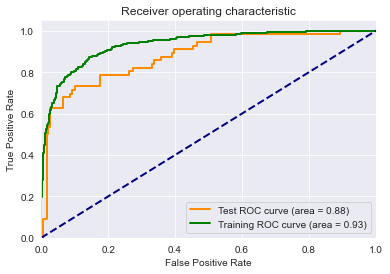

In [336]:
# We plot the ROC curve
plot_roc(y_test, grid_xgboost.predict_proba(X_test)[:,1],y_train, grid_xgboost.predict_proba(X_train)[:,1])

<AxesSubplot:>

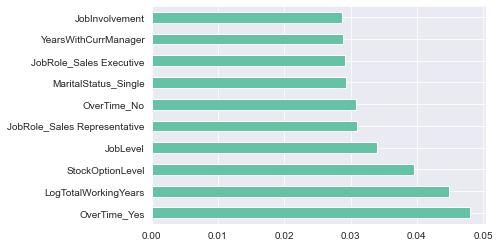

In [337]:
# We plot the feature importance
feat_importances = pd.Series(grid_xgboost.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

## Score test dataset

Read test dataset

In [338]:
# Read the test data
test = pd.read_csv('/Users/pabloserranomolinero/Downloads/playground-series-s3e3/test.csv')
test.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,...,4,80,0,1,2,2,1,0,0,0
1,1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,...,3,80,1,7,3,3,2,2,2,2
2,1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,...,2,80,2,13,2,2,7,7,1,7
3,1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,...,3,80,0,14,2,2,14,10,11,8
4,1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,...,1,80,0,1,5,3,1,0,0,0


Replicate the same feature engineering

In [339]:
# We replicate de transformations we did to the train data

# We list the variables that we want to log transform
log_col = ['MonthlyIncome','TotalWorkingYears','YearsAtCompany']

for cols in log_col:
    test['Log' + cols] = np.log( 1 + test[cols])

# Average years at a company
test['LogAvgYearsAtCompany'] = np.log(df['TotalWorkingYears'] / (df['NumCompaniesWorked'])+1)# If variable is infinity set to 0
test['LogAvgYearsAtCompany'] = test['LogAvgYearsAtCompany'].replace([np.inf, -np.inf], 0)

# We create two new data frames, one with the features and the other with the target
Features = test.loc[:, df.columns.difference(['id','Attrition','MonthlyIncome','TotalWorkingYears','YearsAtCompany'])]
char_features = list(Features.select_dtypes(include=['object']).columns)
Features

# Generate binary values using get_dummies
dum_test = pd.get_dummies(Features[char_features], columns=char_features, prefix=char_features)
X = Features.join(dum_test)
X = X.drop(list(Features.select_dtypes(include=['object']).columns), axis=1)

Predict the target variable

In [340]:
 test['Attrition'] = grid_xgboost.predict_proba(X)[:,1]

 test[['id','Attrition']]

,id,Attrition
0,1677,0.244595
1,1678,0.155718
2,1679,0.110014
3,1680,0.062246
4,1681,0.734273
...,...,...
1114,2791,0.067795
1115,2792,0.022039
1116,2793,0.056794
1117,2794,0.054142


Create submission dataset

In [341]:
test[['id','Attrition']].to_csv('submission.csv', index=False)